## Environment prep

In [ ]:
!pip install hampel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hampel: filename=hampel-1.0.2-cp312-cp312-linux_x86_64.whl size=238941 sha256=222f3083bc3d167860d0967f0769a2f328dadaaf33cf352ba99d6b0cba50481c
  Stored in directory: /root/.cache/pip/wheels/26/b7/c0/993b6604f8a9e7f3dd8753e663ce7bafaf0215c4bfec111100
Successfully built hampel


In [ ]:
from hampel import hampel
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
from math import sqrt, atan2

## Load all data into a list of dataframes

In [ ]:
!git clone https://github.com/thu4n/ESP32-WiFi-Sensing.git

Cloning into 'ESP32-WiFi-Sensing'...
remote: Enumerating objects: 2187, done.
remote: Total 2187 (delta 0), reused 0 (delta 0), pack-reused 2187 (from 1)
Receiving objects: 100% (2187/2187), 238.82 MiB | 19.72 MiB/s, done.
Resolving deltas: 100% (764/764), done.
Updating files: 100% (1339/1339), done.


In [ ]:
main_folder_path = '/content/ESP32-WiFi-Sensing/datasets/01-tvat-raw'

# Lista do przechowywania surowych ramek danych i ich etykiet
raw_activity_dataframes = []
label_list = []

# Iterujemy bezpośrednio przez pliki w folderze głównym
for file_name in sorted(os.listdir(main_folder_path)):
    if file_name.endswith('.csv'):
        # Wyciągnij etykietę (np. 'JJ') z nazwy pliku 'tvat-JJ-1.csv'
        try:
            # Dzielimy nazwę pliku po myślnikach i bierzemy drugi element
            label = file_name.split('-')[1]
        except IndexError:
            # Jeśli nazwa pliku jest inna, pomijamy go
            print(f"Pominięto plik o nietypowej nazwie: {file_name}")
            continue

        file_path = os.path.join(main_folder_path, file_name)

        # Dodajemy etykietę i wczytany DataFrame do list
        label_list.append(label)
        df = pd.read_csv(file_path)
        raw_activity_dataframes.append(df)

print(f"Wczytano {len(raw_activity_dataframes)} surowych plików.")
print(f"Znalezione unikalne etykiety: {sorted(list(set(label_list)))}")

Wczytano 42 surowych plików.
Znalezione unikalne etykiety: ['JJ', 'LA', 'LL', 'NA', 'RA', 'RL', 'SO']


In [ ]:
print(len(raw_activity_dataframes))

42


## Extract amplitude from dataframes

In [ ]:
amp_dataframes = []
# Loop through each file
for df in raw_activity_dataframes:
    # Construct the full path to the file
    data = []
    for _, row in df.iterrows():
      imaginary = []
      real = []
      amplitudes = []

        # Parse string to create integer list
      csi_string = re.findall(r"\[(.*)\]", row['CSI_DATA'])[0]
      csi_raw = [int(x) for x in csi_string.split(" ") if x != '']

        # Create list of imaginary and real numbers from CSI
      for i in range(len(csi_raw)):
          if i % 2 == 0:
              imaginary.append(csi_raw[i])
          else:
              real.append(csi_raw[i])

        # Transform imaginary and real into amplitude and phase
      for i in range(int(len(csi_raw) / 2)):
          amplitudes.append(sqrt(imaginary[i] ** 2 + real[i] ** 2))
      data.append(amplitudes)
    temp_df = pd.DataFrame(data)
    amp_dataframes.append(temp_df)



In [ ]:
print(len(amp_dataframes))
print(len(label_list))

42
42


In [ ]:
print(label_list)

['JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'LA', 'LA', 'LA', 'LA', 'LA', 'LA', 'LL', 'LL', 'LL', 'LL', 'LL', 'LL', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'RA', 'RA', 'RA', 'RA', 'RA', 'RA', 'RL', 'RL', 'RL', 'RL', 'RL', 'RL', 'SO', 'SO', 'SO', 'SO', 'SO', 'SO']


In [ ]:
print(amp_dataframes[1].shape)

(8239, 64)


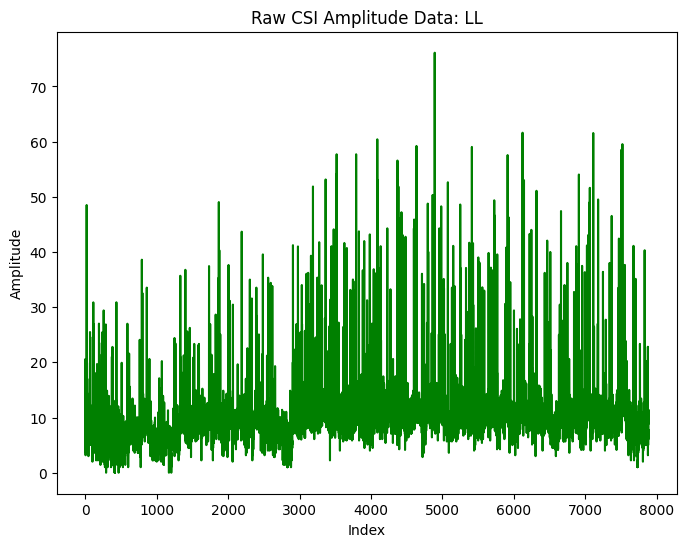

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(amp_dataframes[2][50],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title('Raw CSI Amplitude Data: LL')
plt.show()

In [ ]:
print(amp_dataframes[2][50].head(10))

0    13.341664
1    17.464249
2    15.811388
3    20.591260
4    12.369317
5    18.110770
6    14.142136
7     3.162278
8    12.206556
9    18.681542
Name: 50, dtype: float64


## Apply noise filter

In [ ]:
denoised_dataframes = []
for amplitude in amp_dataframes:
    filtered_data = pd.DataFrame()
    for col in amplitude.columns:
      col_series = amplitude[col]
      # Hampel filter
      hampel_filtered = hampel(col_series, window_size=10)
      # Savitzky-Golay filter
      sg_filtered = savgol_filter(hampel_filtered.filtered_data, window_length=10, polyorder=3)
      filtered_data[col] = sg_filtered
    denoised_dataframes.append(filtered_data)


In [ ]:
print(len(denoised_dataframes))

42


In [ ]:
#path = '/content/ESP32-WiFi-Sensing/datasets/02-tvat-filtered'
for i, dataframe in enumerate(denoised_dataframes):
  filename = f"{label_list[i]}-{i+1}.csv"
  dataframe.to_csv(filename, index=False)


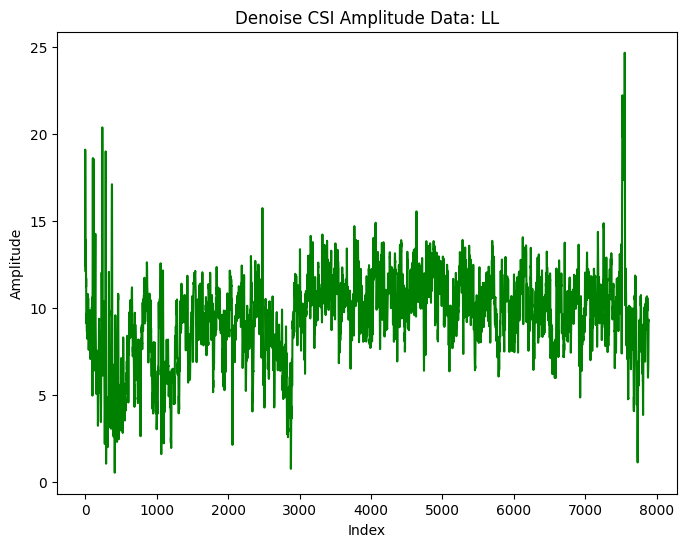

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(denoised_dataframes[2][50],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title('Denoise CSI Amplitude Data: LL')
plt.show()

In [ ]:
print(denoised_dataframes[2][50].head(10))

0    12.400706
1    17.498558
2    19.089205
3    18.188532
4    15.812417
5    12.770979
6    13.586910
7    12.086998
8    12.080665
9    12.206297
Name: 50, dtype: float32


## Segmentation

In [ ]:
segment_dataframes = []
labels = []
for i, df in enumerate(amp_dataframes):
  df_len = len(df)
  #df['label'] = label_list[i]
  df.drop(df.columns[-1],axis=1,inplace=True)
  segment_len = (df_len//200)*200
  rows_to_skip = len(df) - segment_len
  rounded_df = df.iloc[rows_to_skip:]
  segment_df = np.array_split(rounded_df, range(200, len(rounded_df), 200))
  for segment in segment_df:
    segment_dataframes.append(segment)
    labels.append(label_list[i])


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.

In [ ]:
segment_dataframes_raw = []
labels = []
segment_length = 200

for i, df in enumerate(denoised_dataframes):
    num_full_segments = len(df) // segment_length
    if num_full_segments > 0:
        rows_to_skip = len(df) - (num_full_segments * segment_length)
        rounded_df = df.iloc[rows_to_skip:]

        split_indices = range(segment_length, len(rounded_df), segment_length)
        segment_list = np.array_split(rounded_df, split_indices)

        for segment in segment_list:
            if len(segment) == segment_length:
                segment_dataframes_raw.append(segment)
                labels.append(label_list[i])

print(f"Utworzono {len(segment_dataframes_raw)} segmentów o długości {segment_length} próbek każdy.")

columns_to_drop_indices = [2, 3, 4, 5, 32, 59, 60, 61, 62, 63]
segment_dataframes = []

for df in segment_dataframes_raw:
    # Upewniamy się, że nazwy kolumn są liczbami całkowitymi od 0 do N-1
    df.columns = range(df.shape[1])

    # Usuwamy kolumny po ich nazwach (indeksach liczbowych)
    trimmed_df = df.drop(columns=columns_to_drop_indices, axis=1)
    segment_dataframes.append(trimmed_df)

print(f"Usunięto zbędne kolumny. Kształt pierwszego segmentu: {segment_dataframes[0].shape}")

Utworzono 1378 segmentów o długości 200 próbek każdy.
Usunięto zbędne kolumny. Kształt pierwszego segmentu: (200, 54)


In [ ]:
print(len(segment_dataframes))
print(len(labels))

1378
1378


In [ ]:
print(segment_dataframes[3])

             0    1          6          7          8          9          10  \
727  105.603027  4.0  14.726562  14.556728  14.888833  15.309074  14.719120   
728  105.603027  4.0  14.442795  14.461101  14.879280  14.782809  14.592785   
729  105.603027  4.0  14.762171  14.687947  15.543848  15.207851  14.368304   
730  105.603027  4.0  15.389274  15.831218  16.026134  16.002970  14.706366   
731  105.603027  4.0  14.940010  15.677933  16.220615  16.043217  14.274907   
..          ...  ...        ...        ...        ...        ...        ...   
922  105.603027  4.0  16.008072  17.870375  16.779522  17.435205  19.615734   
923  105.603027  4.0  16.507053  18.157635  17.916174  17.635464  20.346935   
924  105.603027  4.0  16.751745  17.702085  18.209887  17.719177  20.272753   
925  105.603027  4.0  17.094727  17.902847  18.765209  18.624504  19.926197   
926  105.603027  4.0  17.932039  18.018686  19.594769  19.043999  19.156403   

            11         12         13  ...         4

## Modele

In [ ]:
# Convert DataFrames to matrices
matrix_list = [df.values for df in segment_dataframes]

# Stack matrices vertically
stacked_matrix = np.vstack(matrix_list)

In [ ]:
dataset_array = np.concatenate(segment_dataframes, axis=0)

In [ ]:
print(matrix_list.shape)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
print(stacked_matrix)

NameError: name 'stacked_matrix' is not defined

In [ ]:
print(X_train.shape)

NameError: name 'X_train' is not defined

In [ ]:
#LeNet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input

model = keras.Sequential([
    Input(shape=(200, 54, 1)),

    layers.Conv2D(32, kernel_size=(7, 7), strides=(3, 1), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, kernel_size=(5, 4), strides=(2, 2), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(96, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.Dense(7) #the output consists of logits, with num_classes = 7
])

# Model compiled with loss='...' (from_logits=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 65, 47, 32)     │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 14, 10, 64)     │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 5, 3, 96)       │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 1, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 1, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,623 (482.90 KB)

 Trainable params: 123,623 (482.90 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def Block(x, filters, stride=1):
    identity = x

    out = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    out = layers.BatchNormalization()(out)
    out = layers.ReLU()(out)

    out = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(out)
    out = layers.BatchNormalization()(out)

    if stride != 1 or x.shape[-1] != filters:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, use_bias=False)(identity)
        identity = layers.BatchNormalization()(identity)

    out = layers.add([out, identity])
    out = layers.ReLU()(out)
    return out

num_classes = 7
inputs = layers.Input(shape=(200,54,1))

x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

x = Block(x, filters=64)
x = Block(x, filters=64)

x = Block(x, filters=128, stride=2)
x = Block(x, filters=128)

x = Block(x, filters=256, stride=2)
x = Block(x, filters=256)

x = Block(x, filters=512, stride=2)
x = Block(x, filters=512)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes)(x)

resnet18_model = keras.Model(inputs=inputs, outputs=outputs, name="ResNet18")

resnet18_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

resnet18_model.summary()

Model: "ResNet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 200, 54,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 100, 27,   │      3,136 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 27,   │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 100, 27,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 50, 14,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 50, 14,    │     36,864 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 14,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 50, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 50, 14,    │     36,864 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 14,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 50, 14,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 50, 14,    │     36,864 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 14,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 50, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 50, 14,    │     36,864 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 14,    │        256 │ conv2d_23[0][0] 

 Total params: 11,183,431 (42.66 MB)

 Trainable params: 11,173,831 (42.62 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def Bottleneck(x, filters, stride=1):
    identity = x
    expansion = 4

    out = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    out = layers.BatchNormalization()(out)
    out = layers.ReLU()(out)

    out = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(out)
    out = layers.BatchNormalization()(out)
    out = layers.ReLU()(out)

    out = layers.Conv2D(filters * expansion, kernel_size=1, strides=1, padding='same', use_bias=False)(out)
    out = layers.BatchNormalization()(out)

    if stride != 1 or x.shape[-1] != filters * expansion:
        identity = layers.Conv2D(filters * expansion, kernel_size=1, strides=stride, use_bias=False)(identity)
        identity = layers.BatchNormalization()(identity)

    out = layers.add([out, identity])
    out = layers.ReLU()(out)
    return out

input_shape = (200, 54, 1)
num_classes = 7
inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

x = Bottleneck(x, filters=64)
x = Bottleneck(x, filters=64)
x = Bottleneck(x, filters=64)

x = Bottleneck(x, filters=128, stride=2)
x = Bottleneck(x, filters=128)
x = Bottleneck(x, filters=128)
x = Bottleneck(x, filters=128)

x = Bottleneck(x, filters=256, stride=2)
x = Bottleneck(x, filters=256)
x = Bottleneck(x, filters=256)
x = Bottleneck(x, filters=256)
x = Bottleneck(x, filters=256)
x = Bottleneck(x, filters=256)

x = Bottleneck(x, filters=512, stride=2)
x = Bottleneck(x, filters=512)
x = Bottleneck(x, filters=512)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes)(x)

resnet50_model = keras.Model(inputs=inputs, outputs=outputs, name="ResNet50")


resnet50_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

resnet50_model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200, 54,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 100, 27,   │      3,136 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 27,   │        256 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_49 (ReLU)     │ (None, 100, 27,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 50, 14,    │          0 │ re_lu_49[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 50, 14,    │      4,096 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 14,    │        256 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_50 (ReLU)     │ (None, 50, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 50, 14,    │     36,864 │ re_lu_50[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 14,    │        256 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_51 (ReLU)     │ (None, 50, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 50, 14,    │     16,384 │ re_lu_51[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 50, 14,    │     16,384 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 14,    │      1,024 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 14,    │      1,024 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 50, 14,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_52 (ReLU)     │ (None, 50, 14,    │          0 │ add_16[0][0]    

 Total params: 23,569,223 (89.91 MB)

 Trainable params: 23,516,103 (89.71 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def Bottleneck(x, filters, stride=1):
    identity = x
    expansion = 4

    out = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    out = layers.BatchNormalization()(out)
    out = layers.ReLU()(out)

    out = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(out)
    out = layers.BatchNormalization()(out)
    out = layers.ReLU()(out)

    out = layers.Conv2D(filters * expansion, kernel_size=1, strides=1, padding='same', use_bias=False)(out)
    out = layers.BatchNormalization()(out)

    if stride != 1 or x.shape[-1] != filters * expansion:
        identity = layers.Conv2D(filters * expansion, kernel_size=1, strides=stride, use_bias=False)(identity)
        identity = layers.BatchNormalization()(identity)

    out = layers.add([out, identity])
    out = layers.ReLU()(out)
    return out

input_shape = (200, 54, 1)
num_classes = 7
inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

x = Bottleneck(x, filters=64)
x = Bottleneck(x, filters=64)
x = Bottleneck(x, filters=64)

x = Bottleneck(x, filters=128, stride=2)
x = Bottleneck(x, filters=128)
x = Bottleneck(x, filters=128)
x = Bottleneck(x, filters=128)

x = Bottleneck(x, filters=256, stride=2)
for _ in range(22):
    x = Bottleneck(x, filters=256)

x = Bottleneck(x, filters=512, stride=2)
x = Bottleneck(x, filters=512)
x = Bottleneck(x, filters=512)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes)(x)

resnet101_model = keras.Model(inputs=inputs, outputs=outputs, name="ResNet101")

resnet101_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

resnet101_model.summary()

Model: "ResNet101"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 54,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 27,   │      3,136 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 27,   │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 100, 27,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 14,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 50, 14,    │      4,096 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 14,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 50, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 50, 14,    │     36,864 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 14,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 50, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 14,    │     16,384 │ re_lu_2[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 50, 14,    │     16,384 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 14,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 14,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 14,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 50, 14,    │          0 │ add[0][0]       

 Total params: 42,613,575 (162.56 MB)

 Trainable params: 42,508,231 (162.16 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [ ]:
#RNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

rnn_model = keras.Sequential([
    layers.Reshape((200, 54), input_shape=(200, 54, 1)),
    layers.SimpleRNN(64),
    layers.Dense(7)
])


rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


rnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 200, 54)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         7,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,071 (31.53 KB)

 Trainable params: 8,071 (31.53 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#GRU
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

gru_model = keras.Sequential([
    layers.Reshape((200, 54), input_shape=(200, 54, 1)),
    layers.GRU(64),
    layers.Dense(7)
])


gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


gru_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 200, 54)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,495 (91.78 KB)

 Trainable params: 23,495 (91.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


lstm_model = keras.Sequential([
    layers.LSTM(64),
    layers.Dense(7)
])


lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 200, 54)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        30,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,919 (120.78 KB)

 Trainable params: 30,919 (120.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#BiLSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

bilstm_model = keras.Sequential([
    layers.Reshape((200, 54), input_shape=(200, 54, 1)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(7)
])

bilstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

bilstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)             │ (None, 200, 54)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        60,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,831 (241.53 KB)

 Trainable params: 61,831 (241.53 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#CCN+GRU
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

cnn_gru_model = keras.Sequential([
    layers.Reshape((200, 54), input_shape=(200, 54, 1)),
    layers.Conv1D(filters=64, kernel_size=12, strides=3, activation='relu'),
    layers.Conv1D(filters=128, kernel_size=5, strides=2, activation='relu'),
    layers.Conv1D(filters=256, kernel_size=5, strides=1, activation='relu'),
    layers.GRU(128),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

cnn_gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_gru_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 200, 54)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 63, 64)         │        41,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 26, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,847 (1.51 MB)

 Trainable params: 395,847 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
class Patches(layers.Layer):
    def __init__(self, patch_height, patch_width):
        super().__init__()
        self.patch_height = patch_height
        self.patch_width = patch_width

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_height, self.patch_width, 1],
            strides=[1, self.patch_height, self.patch_width, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

input_shape = (200, 54, 1)
num_classes = 7
patch_height, patch_width = 20, 9
num_patches = (200 // patch_height) * (54 // patch_width)
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 4

inputs = layers.Input(shape=input_shape)
patches = Patches(patch_height, patch_width)(inputs)
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

for _ in range(transformer_layers):
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    x2 = layers.Add()([attention_output, encoded_patches])

    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = layers.Dense(transformer_units[0], activation=tf.nn.gelu)(x3)
    x3 = layers.Dropout(0.1)(x3)
    x3 = layers.Dense(transformer_units[1])(x3)
    x3 = layers.Dropout(0.1)(x3)
    encoded_patches = layers.Add()([x3, x2])


representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = layers.GlobalAvgPool1D()(representation)
representation = layers.Dropout(0.5)(representation)
outputs = layers.Dense(num_classes)(representation)


vit_model = keras.Model(inputs=inputs, outputs=outputs, name="VisionTransformer")


vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


vit_model.summary()

Model: "VisionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 200, 54,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 180) │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 60, 64)    │     15,424 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 64)    │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 60, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 60, 128)   │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 60, 64)    │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 60, 64)    │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 64)    │          0 │ dropout_3[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 60, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 60, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 60, 128)   │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 60, 64)    │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 348,807 (1.33 MB)

 Trainable params: 348,807 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Konwersja, Standaryzacja i Zmiana Kształtu
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder # Ten import też Ci się przyda do kroku #4
# 1. Konwersja do NumPy
X = np.array([df.values for df in segment_dataframes], dtype=np.float32)
y_str = np.array(labels)

# 2. Standaryzacja
scaler = StandardScaler()
n_samples, height, width = X.shape
X_reshaped = X.reshape(n_samples, height * width)
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(n_samples, height, width)

# 3. Dodanie wymiaru kanału dla Keras
X = np.expand_dims(X, axis=-1)

# 4. Kodowanie etykiet
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_str)
num_classes = len(label_encoder.classes_)

print(f"Ostateczny kształt danych wejściowych (X): {X.shape}")
print(f"Liczba klas do rozpoznania: {num_classes}")
print(f"Klasy: {label_encoder.classes_}")

Ostateczny kształt danych wejściowych (X): (1378, 200, 54, 1)
Liczba klas do rozpoznania: 7
Klasy: ['JJ' 'LA' 'LL' 'NA' 'RA' 'RL' 'SO']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Rozmiar zbioru treningowego: {len(X_train)} próbek")
print(f"Rozmiar zbioru testowego: {len(X_test)} próbek")
print("-" * 30)

print("Rozpoczynanie treningu modelu...")
history = vit_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test)
)

print("-" * 30)
print("Trening zakończony!")

Rozmiar zbioru treningowego: 1102 próbek
Rozmiar zbioru testowego: 276 próbek
------------------------------
Rozpoczynanie treningu modelu...
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.1401 - loss: 2.2598 - val_accuracy: 0.3696 - val_loss: 1.7383
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 346ms/step - accuracy: 0.2926 - loss: 1.8470 - val_accuracy: 0.4022 - val_loss: 1.5148
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step - accuracy: 0.3985 - loss: 1.5905 - val_accuracy: 0.4710 - val_loss: 1.3919
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 359ms/step - accuracy: 0.4493 - loss: 1.4695 - val_accuracy: 0.5036 - val_loss: 1.2953
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 358ms/step - accuracy: 0.4664 - loss: 1.3817 - val_accuracy: 0.5435 - val_loss: 1.3312
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 317ms/step - accuracy: 0.5419 - loss: 1.2791 - val_accuracy: 0.5725 - val_loss: 1.2521
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 365ms/step - accuracy: 0.5953 - loss: 1.17

In [ ]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!cat /proc/cpuinfo | grep "model name" | head -n 1
!grep MemTotal /proc/meminfo


model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
MemTotal:       13286964 kB
